## Target Trial Emulation with Clustering

### 1. Import Libraries

In [50]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

### 2. Process data: compute weights, prepare survival data

In [51]:

data = pd.read_csv('dataset/data_censored.csv')

def process_estimand(data, estimand_type):
    if estimand_type == 'PP':
        # Treatment (switch) model only for PP
        eligible_data = data[data['eligible'] == 1].copy()
        
        # Fit numerator and denominator models for treatment
        numerator_model = smf.glm('treatment ~ age', eligible_data, 
                                  family=sm.families.Binomial()).fit()
        denominator_model = smf.glm('treatment ~ age + x1 + x3', eligible_data, 
                                    family=sm.families.Binomial()).fit()
        
        # Predict treatment probabilities
        eligible_data['num_prob_tx'] = numerator_model.predict(eligible_data)
        eligible_data['denom_prob_tx'] = denominator_model.predict(eligible_data)
        
        # Compute stabilized treatment weights
        eligible_data['tx_num'] = np.where(eligible_data['treatment'] == 1,
                                           eligible_data['num_prob_tx'],
                                           1 - eligible_data['num_prob_tx'])
        eligible_data['tx_denom'] = np.where(eligible_data['treatment'] == 1,
                                             eligible_data['denom_prob_tx'],
                                             1 - eligible_data['denom_prob_tx'])
        eligible_data['sw_weight'] = eligible_data['tx_num'] / eligible_data['tx_denom']
        
        # Merge back to original data and set missing weights to 1
        sw_weights = eligible_data[['id', 'period', 'sw_weight']]
        data_processed = pd.merge(data, sw_weights, on=['id', 'period'], how='left')
        data_processed.loc[:, 'sw_weight'] = data_processed['sw_weight'].fillna(1)
    else:
        # ITT: no treatment weighting
        data_processed = data.copy()
        data_processed['sw_weight'] = 1
    
    # Censoring models: fit numerator and denominator models for censoring
    numerator_formula = 'censored ~ x2'
    denominator_formula = 'censored ~ x2 + x1'
    censor_num_model = smf.glm(numerator_formula, data_processed,
                               family=sm.families.Binomial()).fit()
    censor_denom_model = smf.glm(denominator_formula, data_processed,
                                 family=sm.families.Binomial()).fit()
    
    # Predict censoring probabilities
    data_processed['num_prob_censor'] = censor_num_model.predict(data_processed)
    data_processed['denom_prob_censor'] = censor_denom_model.predict(data_processed)
    
    # Compute censoring weights
    data_processed['cw_num'] = np.where(data_processed['censored'] == 1,
                                        data_processed['num_prob_censor'],
                                        1 - data_processed['num_prob_censor'])
    data_processed['cw_denom'] = np.where(data_processed['censored'] == 1,
                                          data_processed['denom_prob_censor'],
                                          1 - data_processed['denom_prob_censor'])
    data_processed['cw_weight'] = data_processed['cw_num'] / data_processed['cw_denom']
    
    # Compute cumulative weights over periods
    data_sorted = data_processed.sort_values(['id', 'period'])
    data_sorted['cum_sw'] = data_sorted.groupby('id')['sw_weight'].cumprod()
    data_sorted['cum_cw'] = data_sorted.groupby('id')['cw_weight'].cumprod()
    data_sorted['cum_weight'] = data_sorted['cum_sw'] * data_sorted['cum_cw']
    
    # Drop periods after censoring
    data_sorted['censored_ever'] = data_sorted.groupby('id')['censored'].cummax()
    data_filtered = data_sorted[data_sorted['censored_ever'] == 0].copy()
    
    # Winsorize weights at the 99th percentile
    q99 = data_filtered['cum_weight'].quantile(0.99)
    data_filtered.loc[:, 'cum_weight_win'] = np.minimum(data_filtered['cum_weight'], q99)
    
    # Prepare for survival analysis
    data_filtered.loc[:, 'start'] = data_filtered['period']
    data_filtered.loc[:, 'stop'] = data_filtered['period'] + 1
    data_filtered.loc[:, 'event'] = data_filtered['outcome']
    
    # Mimic trial expansion: assigned_treatment equals treatment
    data_filtered.loc[:, 'assigned_treatment'] = data_filtered['treatment']
    
    return data_filtered


# Process data (here we use ITT as an example)
itt_data = process_estimand(data, 'ITT')
itt_data.head()

,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,...,cw_weight,cum_sw,cum_cw,cum_weight,censored_ever,cum_weight_win,start,stop,event,assigned_treatment
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,...,0.955481,1,0.955481,0.955481,0,0.955481,0,1,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,...,0.970647,1,0.927435,0.927435,0,0.927435,1,2,0,1
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,...,1.016972,1,0.943175,0.943175,0,0.943175,2,3,0,1
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,...,1.021899,1,0.963830,0.963830,0,0.963830,3,4,0,1
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,...,0.968208,1,0.933187,0.933187,0,0.933187,4,5,0,1


### 3. Apply k-means clustering to identify patient subgroups

In [52]:
# Choose baseline features for clustering
features = ['age', 'x1', 'x2', 'x3']
data_for_clustering = itt_data[features].copy()

# Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

# Number of clusters
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
itt_data['cluster'] = kmeans.fit_predict(data_scaled)

# Summarize cluster characteristics
cluster_summary = itt_data.groupby('cluster').agg({
    'age': 'mean',
    'x1': 'mean',
    'x2': 'mean',
    'x3': 'mean',
    'outcome': 'mean',
    'treatment': 'mean'
}).reset_index()

print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
   cluster        age       x1        x2   x3   outcome  treatment
0        0  47.258883  0.00000 -0.382693  1.0  0.015228   0.446701
1        1  50.726744  0.44186 -0.117365  0.0  0.008721   0.453488
2        2  47.642857  1.00000 -0.190995  1.0  0.023810   0.500000


### 4. Get Silhouette Score

In [53]:
sil_score = silhouette_score(data_scaled, itt_data['cluster'])
print("Silhouette Score:", sil_score)

Silhouette Score: 0.27176495411315327


### 5. Visualize clusters in 2D using PCA

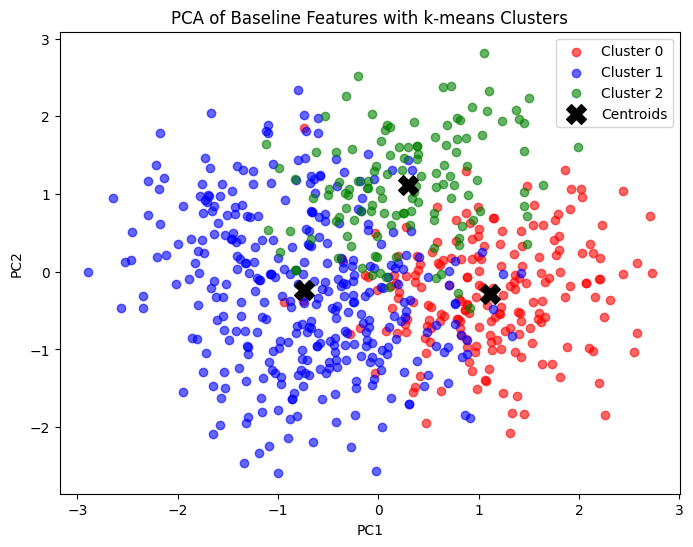

In [54]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

itt_data['PC1'] = data_pca[:, 0]
itt_data['PC2'] = data_pca[:, 1]

plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green', 'orange', 'purple']  # Extend if k>5
for cluster in range(k):
    cluster_data = itt_data[itt_data['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], 
                label=f'Cluster {cluster}', alpha=0.6, c=colors[cluster % len(colors)])

# Plot centroids in PCA space
centers = kmeans.cluster_centers_
centers_pca = pca.transform(centers)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], marker='X', s=200, c='black', label='Centroids')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Baseline Features with k-means Clusters")
plt.legend()
plt.show()


### 6. Fit a Cox proportional hazards model including cluster as a covariate (ITT)

In [55]:
cph_with_cluster = CoxPHFitter()
cph_with_cluster.fit(
    itt_data, 
    duration_col='stop', 
    event_col='event', 
    entry_col='start',
    weights_col='cum_weight_win', 
    formula="treatment + x2 + C(cluster)", 
    robust=True
)
print(cph_with_cluster.print_summary())

model,lifelines.CoxPHFitter
duration col,'stop'
event col,'event'
weights col,'cum_weight_win'
entry col,'start'
robust variance,True
baseline estimation,breslow
number of observations,663.896
number of events observed,9.16579
partial log-likelihood,-28.50
time fit was run,2025-03-09 14:55:24 UTC


None


### 7. Overall survival difference for a "reference" cluster (the most frequent)

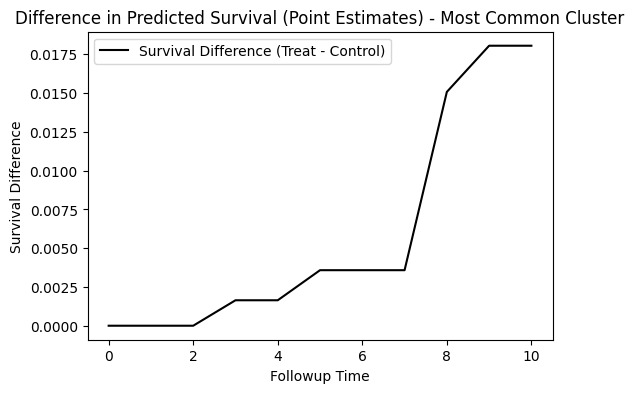

In [56]:
pred_times = np.arange(0, 11)
x2_mean = itt_data['x2'].mean()
cluster_mode = itt_data['cluster'].mode()[0]

df_control = pd.DataFrame({'treatment': [0], 'x2': [x2_mean], 'cluster': [cluster_mode]})
df_treatment = pd.DataFrame({'treatment': [1], 'x2': [x2_mean], 'cluster': [cluster_mode]})

sf_control = cph_with_cluster.predict_survival_function(df_control, times=pred_times)
sf_treatment = cph_with_cluster.predict_survival_function(df_treatment, times=pred_times)

diff_overall = sf_treatment.iloc[:, 0] - sf_control.iloc[:, 0]

plt.figure(figsize=(6, 4))
plt.plot(pred_times, diff_overall, 'k-', label="Survival Difference (Treat - Control)")
plt.xlabel("Followup Time")
plt.ylabel("Survival Difference")
plt.title("Difference in Predicted Survival (Point Estimates) - Most Common Cluster")
plt.legend()
plt.show()

### 8. Plot cluster-specific survival differences

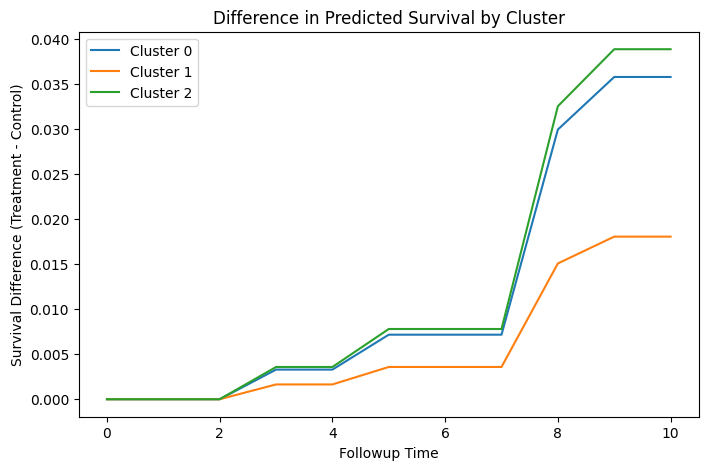

In [57]:
plt.figure(figsize=(8, 5))

for c in range(k):
    # Create dataframes for the reference Control and Treatment subject in cluster c
    df_control_c = pd.DataFrame({'treatment': [0], 'x2': [x2_mean], 'cluster': [c]})
    df_treatment_c = pd.DataFrame({'treatment': [1], 'x2': [x2_mean], 'cluster': [c]})
    
    # Predict survival functions
    sf_control_c = cph_with_cluster.predict_survival_function(df_control_c, times=pred_times)
    sf_treatment_c = cph_with_cluster.predict_survival_function(df_treatment_c, times=pred_times)
    
    # Compute the difference
    diff_c = sf_treatment_c.iloc[:, 0] - sf_control_c.iloc[:, 0]
    
    # Plot each cluster's difference
    plt.plot(pred_times, diff_c, label=f"Cluster {c}")

plt.xlabel("Followup Time")
plt.ylabel("Survival Difference (Treatment - Control)")
plt.title("Difference in Predicted Survival by Cluster")
plt.legend()
plt.show()

#### Insights from Survival Difference Curves:
If some clusters show little to no survival improvement with treatment, it suggests that the intervention may not be universally beneficial. If a particular cluster has a much larger survival benefit, targeted treatment strategies could be developed for similar patients in real-world settings. This could be further extended by testing alternative method, incorporation of additional covariates, or using non-parametric models.

#### Insights from using pre-TTE clustering:
Pre-TTE clustering uncovers hidden subgroups in the population as traditional TTE models treats all individuals as if they belong to the same risk group, allowing treatment effects to be evaluated more precisely. This also means we can estimate the treatment effect separately for each cluster.

K-Means clustering was chosen for this TTE study because it provides a simple, efficient, and interpretable way to divide the study population into clusters based on characteristics. This ensures we compare individuals with similar baseline risks, and allows for cluster-specific survival analysis. This also enables us to identify differential treatment effects across clusters, leading to more personalized insights in epidemiological research.